In [78]:
import pandas as pd

# Load movies and ratings datasets
movies = pd.read_csv('./ml-latest/movies.csv')
ratings = pd.read_csv('./ml-latest/ratings.csv')

# Preview the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [79]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [80]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import numpy as np


In [81]:
movies_df = movies.copy()
movies_df['genres'] = movies_df['genres'].str.split('|')

In [82]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),"[Action, Drama]"
86533,288971,Ouija Japan (2021),"[Action, Horror]"
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),[Documentary]
86535,288977,Skinford: Death Sentence (2023),"[Crime, Thriller]"


In [83]:

mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(movies_df['genres']), columns=mlb.classes_, index=movies_df.index)

In [84]:


# Aggregate ratings to movie-level (popularity / average rating)
movie_stats = ratings.groupby('movieId').agg(average_rating=('rating', 'mean'), rating_count=('rating', 'count')).reset_index()
# Merge stats into movies_df (movies.csv has movieId)
movies_df = movies_df.merge(movie_stats, on='movieId', how='left')
movies_df['average_rating'] = movies_df['average_rating'].fillna(0)
movies_df['rating_count'] = movies_df['rating_count'].fillna(0)


In [85]:
movies_df

,movieId,title,genres,average_rating,rating_count
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893508,76813.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.278179,30209.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.171271,15820.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.868395,3028.0
4,5,Father of the Bride Part II (1995),[Comedy],3.076957,15801.0
...,...,...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),"[Action, Drama]",3.500000,1.0
86533,288971,Ouija Japan (2021),"[Action, Horror]",0.500000,1.0
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),[Documentary],4.000000,1.0
86535,288977,Skinford: Death Sentence (2023),"[Crime, Thriller]",3.000000,1.0


In [86]:
if movies_df['rating_count'].max() > 0:
    movies_df['popularity'] = movies_df['rating_count'] / movies_df['rating_count'].max()
else:
    movies_df['popularity'] = 0

In [87]:

feature_df = genre_dummies.copy()
feature_df['popularity'] = movies_df['popularity'].values * 0.1  # small weight so genres dominate

In [88]:

# Fit a lightweight nearest-neighbors model using cosine distance (fast on small dataset)
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(feature_df.values)

,n_neighbors,6
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [89]:
movies_features = feature_df


In [90]:
print('Number of movies:', len(movies_df))
print('Feature matrix shape:', movies_features.shape)
print('Columns in movies_df:', list(movies_df.columns))

Number of movies: 86537
Feature matrix shape: (86537, 21)
Columns in movies_df: ['movieId', 'title', 'genres', 'average_rating', 'rating_count', 'popularity']


In [91]:
movies_df

,movieId,title,genres,average_rating,rating_count,popularity
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893508,76813.0,0.628091
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.278179,30209.0,0.247015
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.171271,15820.0,0.129358
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.868395,3028.0,0.024760
4,5,Father of the Bride Part II (1995),[Comedy],3.076957,15801.0,0.129203
...,...,...,...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),"[Action, Drama]",3.500000,1.0,0.000008
86533,288971,Ouija Japan (2021),"[Action, Horror]",0.500000,1.0,0.000008
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),[Documentary],4.000000,1.0,0.000008
86535,288977,Skinford: Death Sentence (2023),"[Crime, Thriller]",3.000000,1.0,0.000008


Text(0, 0.5, 'Frequency')

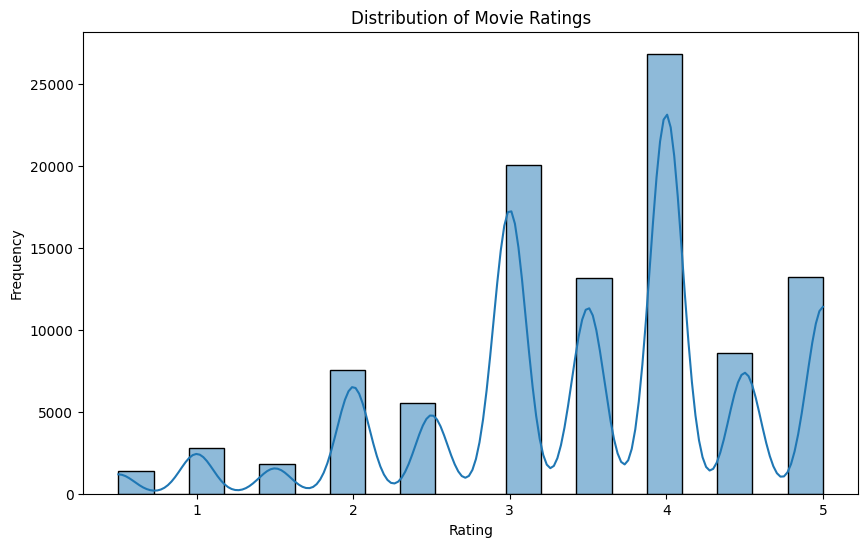

In [92]:


import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(movie_ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')    
plt.ylabel('Frequency')

In [93]:
# Recommendation function using the fitted KNN on movie-level features
def recommend_movies(movie_title, movies_df, features_df, knn_model, n_recommendations=5):
    # Find the movie index in movies_df
    matches = movies_df[movies_df['title'] == movie_title]
    if len(matches) == 0:
        return f"Movie '{movie_title}' not found in the dataset."

    movie_idx = matches.index[0]
    movie_vector = features_df.loc[movie_idx].values.reshape(1, -1)

    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)
    # indices includes the movie itself; exclude it
    rec_indices = [i for i in indices.flatten() if i != movie_idx][:n_recommendations]

    recommendations = movies_df.iloc[rec_indices][['title', 'average_rating', 'rating_count']]
    return recommendations.reset_index(drop=True)

In [94]:
# Try the recommender: should now return distinct movie titles (no duplicates)
recommendations = recommend_movies('Male Hunt (1964)', movies_df, movies_features, knn, n_recommendations=5)
print(recommendations)

                                title  average_rating  rating_count
0         Holiday on the Buses (1973)        3.500000           3.0
1                  Santa Claus (2014)        2.833333           3.0
2  Neurotic Quest for Serenity (2017)        2.666667           3.0
3                  Loose Shoes (1980)        2.333333           3.0
4  Claude Chabrol's High Heels (1972)        3.333333           3.0


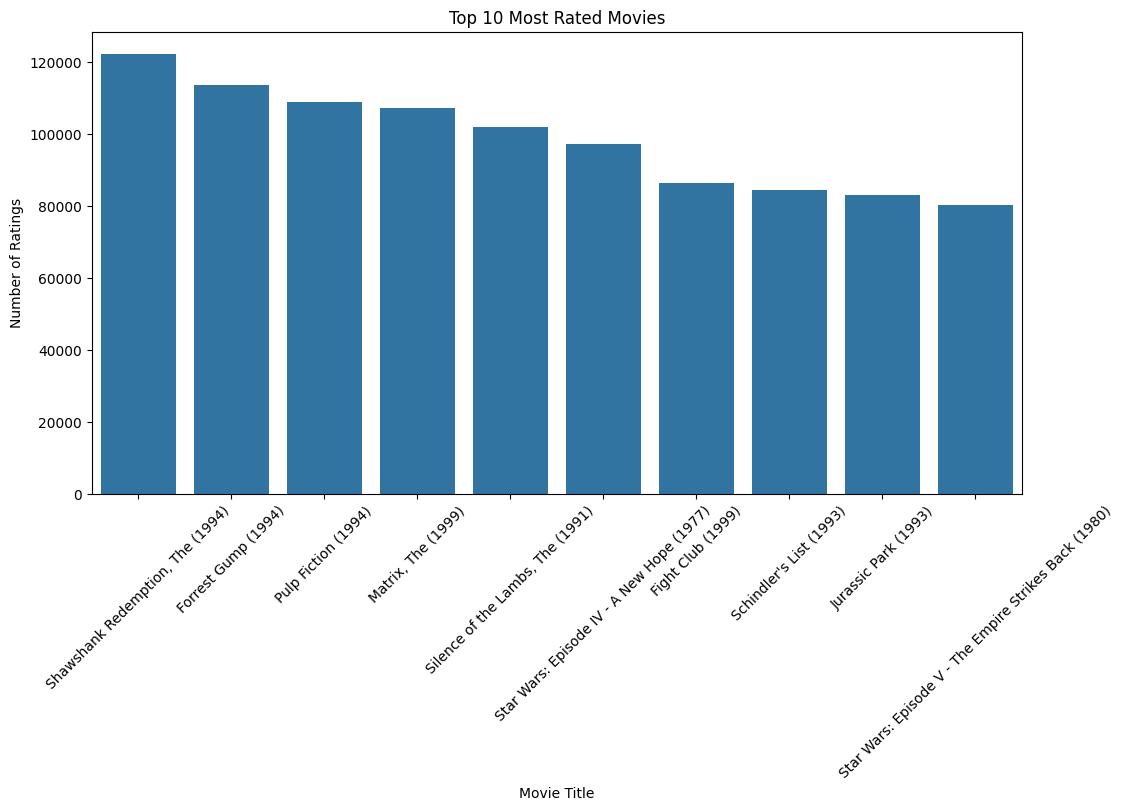

In [95]:
# most popular movies by rating count
top_movies = movies_df.sort_values(by='rating_count', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='title', y='rating_count', data=top_movies)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

In [96]:
# save the model and data
import joblib
# Save the KNN model
joblib.dump(knn, 'knn_movie_recommender.pkl')
joblib.dump(movies_features, 'movies_features.pkl')
# Save the movies DataFrame
movies_df.to_csv('movies_data.csv', index=False)    


In [97]:
# save the entire model and data
import joblib
# Save the KNN model
joblib.dump(knn, 'knn_movie_recommender.pkl')
joblib.dump(movies_features, 'movies_features.pkl')
# Save the movies DataFrame
movies_df.to_csv('movies_data.csv', index=False)    